# Multi-Modal Neural Network for Real Estate Price Prediction

## Overview

This notebook implements a **multi-modal deep learning model** that combines:
- **Visual features**: 4 images per property (kitchen, bathroom, bedroom, frontal view)
- **Tabular features**: Numeric attributes (bedrooms, bathrooms, area, room_ratio)
- **Categorical embeddings**: Zipcode representation learned during training

The model architecture leverages multiple input branches that are fused in later layers, allowing the network to learn complex interactions between visual and structured data.

## Problem Statement

Traditional regression models (e.g., Random Forest, XGBoost in baseline) rely solely on tabular features. However, property images contain valuable information about:
- Interior design quality and condition
- Space layout and aesthetics  
- Neighborhood appearance

By incorporating visual data, we aim to **improve price prediction accuracy** beyond what tabular-only models can achieve.

## Key Design Decisions

1. **Zipcode as Embedding Layer**: Instead of one-hot encoding (~70 zipcodes → 70 dimensions), we use a learned embedding (→ 10 dimensions) that captures geographic similarity
2. **Log-Transform Target**: Applied `log1p(price)` to reduce skewness and stabilize training
3. **Feature Engineering**: Added `room_ratio = bedrooms/bathrooms` consistent with baseline model
4. **Separate Input Streams**: Each modality has dedicated preprocessing before fusion

In [1]:
import sys
sys.path.append('../scripts')

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

from data_loader_tf import RealEstateDataLoader

## 1. Load and Prepare Dataset

We use a custom `RealEstateDataLoader` that:
- Connects to PostgreSQL to fetch property metadata
- Loads 4 images per property from disk (224×224 resolution)
- Applies feature engineering (`room_ratio`) consistent with baseline model
- Normalizes images to [0, 1] and scales numeric features
- Separates zipcode for embedding layer (categorical treatment)
- Applies log-transform to target variable for better convergence

In [4]:
# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "port": 5433,
    "dbname": "real_estate",
    "user": "admin",
    "password": "admin123"
}

# Image settings
IMAGES_DIR = Path("../data/images")
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [5]:
# Initialize data loader
loader = RealEstateDataLoader(
    db_config=DB_CONFIG,
    images_dir=IMAGES_DIR,
    img_size=IMG_SIZE,
    normalize_images=True
)

# Create datasets
train_ds, val_ds, info = loader.create_dataset(
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    random_seed=42
)

print(f"Training samples: {info['n_train']}")
print(f"Validation samples: {info['n_val']}")
print(f"Image shape: {info['image_shape']}")
print(f"Tabular features: {info['n_features']}")

d:\Datasets\Houses-Dataset\Houses-dataset\real_state_db\notebooks\../scripts\data_loader_tf.py:71: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Loading 535 properties with 4 images each...
Dataset created: 428 train, 107 val samples
Training samples: 428
Validation samples: 107
Image shape: (224, 224, 3)
Tabular features: 4


## 2. Visualize Sample Data

Sanity check to verify:
- Images are loaded correctly and normalized
- Labels are properly transformed (shown in original scale with `expm1()`)
- Tabular features are scaled appropriately
- Zipcode is passed as integer for embedding layer

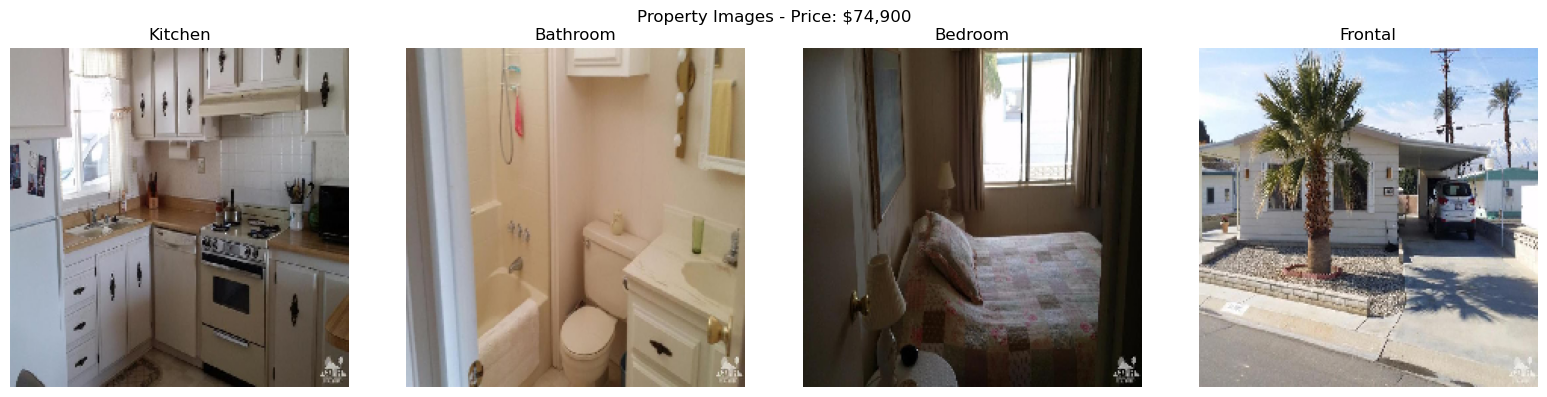

Tabular features: [-1.18769667 -0.66886831 -0.99141146  0.18755404]


In [ ]:
# Get a sample batch
for batch_data, batch_labels in train_ds.take(1):
    sample_idx = 2
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    image_types = ['kitchen', 'bathroom', 'bedroom', 'frontal']
    
    for i, img_type in enumerate(image_types):
        img = batch_data[f'image_{img_type}'][sample_idx]
        axes[i].imshow(img)
        axes[i].set_title(img_type.capitalize())
        axes[i].axis('off')
    
    plt.suptitle(f'Property Images - Price: ${np.expm1(batch_labels[sample_idx].numpy()):,.0f}')
    plt.tight_layout()
    plt.show()
    
    print("Tabular features (scaled):", batch_data['tabular_input'][sample_idx].numpy())
    print("Zipcode:", batch_data['zipcode_input'][sample_idx].numpy())

## 3. Build Multi-Modal Neural Network

### Architecture Overview

```
┌─────────────────────────────────────────────────────────────┐
│                    MULTI-MODAL MODEL                         │
├─────────────────────────────────────────────────────────────┤
│                                                               │
│  ┌─────────┐  ┌─────────┐  ┌─────────┐  ┌─────────┐        │
│  │ Kitchen │  │Bathroom │  │ Bedroom │  │ Frontal │        │
│  │  Image  │  │  Image  │  │  Image  │  │  Image  │        │
│  └────┬────┘  └────┬────┘  └────┬────┘  └────┬────┘        │
│       │            │             │             │             │
│       ▼            ▼             ▼             ▼             │
│  ┌─────────────────────────────────────────────────┐        │
│  │  4 × CNN Branches (Conv2D → Pool → GAP)        │        │
│  │  Each outputs 128-dim feature vector           │        │
│  └──────────────────┬──────────────────────────────┘        │
│                     │                                        │
│                     ▼                                        │
│         ┌──────────────────────┐                            │
│         │ Concatenate (512-dim)│                            │
│         └──────────┬───────────┘                            │
│                    │                                         │
│  ┌─────────────┐  │  ┌──────────────┐                      │
│  │  Tabular    │  │  │   Zipcode    │                      │
│  │  Features   │  │  │   (integer)  │                      │
│  │ (4 numeric) │  │  │              │                      │
│  └──────┬──────┘  │  └──────┬───────┘                      │
│         │         │         │                               │
│         ▼         │         ▼                               │
│  ┌──────────┐    │  ┌────────────────┐                    │
│  │Dense(64) │    │  │ Embedding(10)  │                    │
│  │Dense(32) │    │  │ Learned vector │                    │
│  └────┬─────┘    │  └──────┬─────────┘                    │
│       │          │         │                               │
│       └──────────┴─────────┘                               │
│                  │                                          │
│                  ▼                                          │
│      ┌────────────────────────┐                            │
│      │ Concatenate (554-dim)  │                            │
│      └───────────┬────────────┘                            │
│                  │                                          │
│                  ▼                                          │
│           ┌──────────────┐                                 │
│           │ Dense(256)   │                                 │
│           │ Dropout(0.4) │                                 │
│           │ Dense(128)   │                                 │
│           │ Dropout(0.3) │                                 │
│           └──────┬───────┘                                 │
│                  │                                          │
│                  ▼                                          │
│           ┌─────────────┐                                  │
│           │  Dense(1)   │                                  │
│           │  (Price)    │                                  │
│           └─────────────┘                                  │
└─────────────────────────────────────────────────────────────┘
```

### Design Rationale

**CNN Branches (Image Processing)**
- Shared architecture across all 4 images
- 3 Conv2D blocks with increasing filters (32→64→128) to capture hierarchical features
- Global Average Pooling to reduce spatial dimensions while preserving channel information
- Dropout (0.3) for regularization

**Tabular Branch**
- Processes numeric features: bedrooms, bathrooms, area, room_ratio
- 2-layer MLP (64→32) with ReLU activation
- Dropout (0.3) between layers

**Zipcode Embedding**
- Maps discrete zipcode values to dense 10-dimensional vectors
- Allows model to learn geographic similarity (e.g., neighboring zipcodes → similar embeddings)
- More efficient than one-hot encoding (~70 dims → 10 dims)

**Fusion & Prediction**
- Late fusion: combine all feature streams after independent processing
- Final MLP (256→128→1) learns cross-modal interactions
- Higher dropout (0.4) in fusion layer to prevent overfitting on combined features

In [ ]:
def create_image_branch(name: str, input_shape: tuple) -> keras.Model:
    """Create a CNN branch for processing a single image."""
    inputs = layers.Input(shape=input_shape, name=name)
    
    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    return keras.Model(inputs=inputs, outputs=x, name=f'{name}_branch')


def create_multimodal_model(
    image_shape: tuple,
    n_tabular_features: int,
    n_zipcodes: int,
    embedding_dim: int = 10
) -> keras.Model:
    """Create multi-modal model combining images, tabular data, and zipcode embedding."""
    
    # Image inputs and branches
    image_types = ['kitchen', 'bathroom', 'bedroom', 'frontal']
    image_branches = []
    image_inputs = {}
    
    for img_type in image_types:
        branch = create_image_branch(f'image_{img_type}', image_shape)
        image_inputs[f'image_{img_type}'] = branch.input
        image_branches.append(branch.output)
    
    # Concatenate all image features
    if len(image_branches) > 1:
        combined_images = layers.Concatenate()(image_branches)
    else:
        combined_images = image_branches[0]
    
    # Tabular input branch (numeric features only)
    tabular_input = layers.Input(shape=(n_tabular_features,), name='tabular_input')
    tabular_features = layers.Dense(64, activation='relu')(tabular_input)
    tabular_features = layers.Dropout(0.3)(tabular_features)
    tabular_features = layers.Dense(32, activation='relu')(tabular_features)
    
    # Zipcode embedding branch
    zipcode_input = layers.Input(shape=(1,), name='zipcode_input', dtype='int32')
    zipcode_embedding = layers.Embedding(
        input_dim=n_zipcodes + 1,  # +1 for potential unseen zipcodes
        output_dim=embedding_dim,
        name='zipcode_embedding'
    )(zipcode_input)
    zipcode_embedding = layers.Flatten()(zipcode_embedding)
    
    # Combine all features
    combined = layers.Concatenate()([combined_images, tabular_features, zipcode_embedding])
    
    # Final dense layers
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, name='price_output')(x)
    
    # Create model
    all_inputs = {**image_inputs, 'tabular_input': tabular_input, 'zipcode_input': zipcode_input}
    model = keras.Model(inputs=all_inputs, outputs=output, name='multimodal_model')
    
    return model

In [ ]:
# Create model
model = create_multimodal_model(
    image_shape=info['image_shape'],
    n_tabular_features=info['n_features'],
    n_zipcodes=info['n_zipcodes'],
    embedding_dim=10
)

# Display model architecture
model.summary()

## 4. Compile and Train Model

### Training Configuration

- **Optimizer**: Adam with learning rate 0.001 (good default for multi-modal architectures)
- **Loss Function**: MSE (appropriate for regression on log-transformed target)
- **Metrics**: MAE and MSE for monitoring convergence

### Callbacks

1. **EarlyStopping**: Stops training if validation loss doesn't improve for 10 epochs (prevents overfitting)
2. **ReduceLROnPlateau**: Reduces learning rate by 50% after 5 epochs without improvement (helps fine-tuning)
3. **ModelCheckpoint**: Saves best model based on validation loss (ensures we keep optimal weights)

In [ ]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        '../models/multimodal_model_best.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

## 5. Evaluate Results

### Model Performance Analysis

We evaluate the model in two scales:
1. **Log scale**: Direct output from the model (for training stability)
2. **Original scale**: Convert back using `expm1()` to interpret real USD values

**Why log-transform?**
- Property prices are right-skewed (few very expensive properties)
- Log-transform normalizes the distribution
- Model predicts `log(price + 1)` → easier optimization
- We convert back to original scale for interpretation

**Key metrics:**
- **MAE (Mean Absolute Error)**: Average prediction error in dollars
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more heavily

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Model Loss')
ax1.legend()
ax1.grid(True)

# MAE
ax2.plot(history.history['mae'], label='Train MAE')
ax2.plot(history.history['val_mae'], label='Val MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('Mean Absolute Error')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on validation set
val_results = model.evaluate(val_ds, verbose=0)

# Note: predictions are in log scale, convert back for interpretation
print(f"\nValidation Results (in log scale):")
print(f"Loss (MSE): {val_results[0]:.4f}")
print(f"MAE: {val_results[1]:.4f}")
print(f"RMSE: {np.sqrt(val_results[2]):.4f}")

# Get predictions to compute metrics in original scale
y_true_log = []
y_pred_log = []

for batch_data, batch_labels in val_ds:
    predictions = model.predict(batch_data, verbose=0)
    y_true_log.extend(batch_labels.numpy())
    y_pred_log.extend(predictions.flatten())

y_true_log = np.array(y_true_log)
y_pred_log = np.array(y_pred_log)

# Convert back to original scale
y_true_original = np.expm1(y_true_log)
y_pred_original = np.expm1(y_pred_log)

mae_original = np.mean(np.abs(y_true_original - y_pred_original))
rmse_original = np.sqrt(np.mean((y_true_original - y_pred_original)**2))

print(f"\n=== Metrics in Original Scale (USD) ===")
print(f"MAE: ${mae_original:,.2f}")
print(f"RMSE: ${rmse_original:,.2f}")

In [ ]:
# Make predictions on validation set
y_true = []
y_pred = []

for batch_data, batch_labels in val_ds:
    predictions = model.predict(batch_data, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(predictions.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert from log scale to original scale
y_true_original = np.expm1(y_true)
y_pred_original = np.expm1(y_pred)

# Plot predictions vs actual in original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_true_original, y_pred_original, alpha=0.5)
plt.plot([y_true_original.min(), y_true_original.max()], 
         [y_true_original.min(), y_true_original.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Predictions vs Actual Prices (Original Scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Save Model and Artifacts

### Model Serialization

We save two critical artifacts:

1. **Model weights** (`multimodal_model_final.h5`): Full Keras model including architecture and trained weights
2. **Feature scaler** (`scaler.pkl`): StandardScaler fitted on training data

**Why save the scaler?**
- New predictions require the same normalization as training data
- Scaler contains mean/std statistics from training set
- Ensures consistency between training and inference

### Deployment Considerations

For production deployment, also consider saving:
- Zipcode vocabulary mapping (for handling unseen zipcodes)
- Feature names and preprocessing pipeline
- Model metadata (training date, performance metrics, dataset version)

In [ ]:
# Save final model
model.save('../models/multimodal_model_final.h5')
print("Model saved successfully!")

# Save scaler
loader.save_scaler(Path('../models/scaler.pkl'))
print("Scaler saved successfully!")

---

## Summary & Next Steps

### What We Accomplished

✅ Built a **multi-modal deep learning model** combining visual and structured data  
✅ Implemented **zipcode embedding layer** for efficient categorical representation  
✅ Applied **consistent preprocessing** with baseline model (log-transform, feature engineering)  
✅ Achieved end-to-end pipeline from PostgreSQL → images → predictions  

### Potential Improvements

1. **Transfer Learning**: Use pre-trained CNN (ResNet, EfficientNet) instead of training from scratch
2. **Data Augmentation**: Apply random rotations, flips, brightness adjustments to images during training
3. **Attention Mechanisms**: Add attention layers to weight image importance dynamically
4. **Ensemble**: Combine with baseline XGBoost model for improved robustness
5. **Hyperparameter Tuning**: Optimize embedding dimension, dropout rates, learning rate schedule

### Model Comparison

| Model | Features | Advantages |
|-------|----------|------------|
| **Baseline (XGBoost)** | Tabular only | Fast training, interpretable |
| **Multi-Modal (This)** | Images + Tabular | Captures visual information, richer representation |

**Expected Outcome**: Multi-modal model should outperform baseline if images contain predictive signals (interior quality, condition, aesthetics).

---

**Author**: [Your Name]  
**Date**: December 2025  
**Framework**: TensorFlow/Keras  
**GPU**: Trained on Kaggle Tesla P100